#Introduction

Choosing the right house to buy is not an easy task. Although many factors come into play, an important factor to consider is the price. In this project, we are trying to predict the price of a house given many factors that describe most, if not all aspects of a house. That way, a user could have a reasonable price estimate for a house that he/she would like to buy, and know if he/she is getting a good deal or not.

The dataset we will use comes from Kaggle and consists of data from residential homes in Ames, Iowa. Here is the link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

#Loading Data and Libraries

Here we load the data and import the necessary libraries. Some of the key variables to make note of are 
*   SalePrice: price that the house was sold for
*   OverallQual: rates the overall material and finish of the house on a scale of 1-10
*   GrLivArea: living area in square feet
*   GarageCars: size of garage in car capacity





In [ ]:
#import libraries
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statistics
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train.csv') #read in the data

# Data Cleaning

Below is an overview of the data. The dataset consists of 1460 observations and 80 predictors. The predictors consist of qualitative and quantitative data. 43 of the variables in the data are type object, 35 are type int64, and 3 of them are type float64. We will attempt to reduce the number of predictors we will work with in our model. 

In [ ]:
print('Shape of dataset: ' + str(df.shape)) # shape of dataset
df.head() # sample overview of data

Shape of dataset: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
df.dtypes.value_counts() #types of data among the predictors

object     43
int64      35
float64     3
dtype: int64

* Data Cleaning

We first clean and split the data before we can explore it and present some important information.

Since ID is arbitrary, we will drop it from our dataset.

In [ ]:
df.drop('Id', axis = 1, inplace = True)

We turn 'MSSubClass' into a categorical variable, because it represents the type of house and its values have no particular ordering. It seems to us that these numerical values are actually discrete features with specific meanings in the data description file.

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        etc...

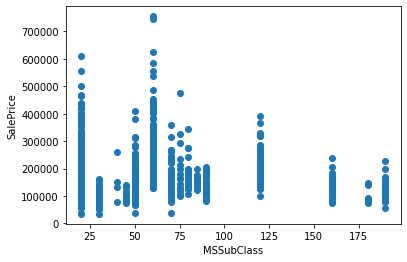

In [ ]:
plt.scatter(df['MSSubClass'], df['SalePrice'])
plt.xlabel('MSSubClass')
plt.ylabel('SalePrice');

In [ ]:
#turn 'MSSubClass' into categorical variable 
df['MSSubClass'] = df['MSSubClass'].astype('object')

As shown in the bar chart below, 'Alley', 'PoolQC', 'Fence', and 'MiscFeature' have 80 percent or more of data missing. So we will drop these variables from our analysis.

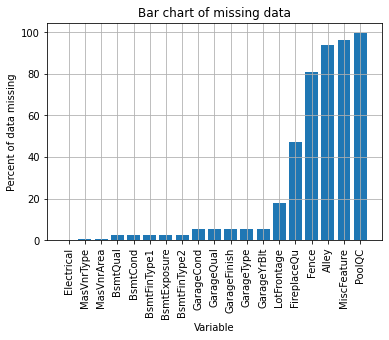

<Figure size 864x864 with 0 Axes>

In [ ]:
num_of_missing = pd.DataFrame(df.isnull().sum()) #number of missing values for each variable 
indx_missing = num_of_missing[num_of_missing.values !=0].sort_values(by = 0).index.tolist() #list of variables which have data missing 
num_of_missing = num_of_missing[num_of_missing.values !=0].sort_values(by = 0).values[:,0].tolist()
pct_missing = [x/len(df)*100 for x in num_of_missing]
plt.bar(indx_missing,pct_missing) #plot bar graph of percent of data missing for each variable
plt.grid(True)
plt.xticks(rotation = 'vertical')
plt.xlabel('Variable')
plt.ylabel('Percent of data missing')
plt.title('Bar chart of missing data')
plt.figure(figsize = (12,12))
df.drop(['Alley', 'PoolQC','Fence','MiscFeature'], axis = 1, inplace = True) #drop variables

Some numerical variables have very small range with very few big outliers. And we are not sure how the values are obtained. For example:

KitchenAbvGr: No description in the data description file

MiscVal: $Value of miscellaneous feature

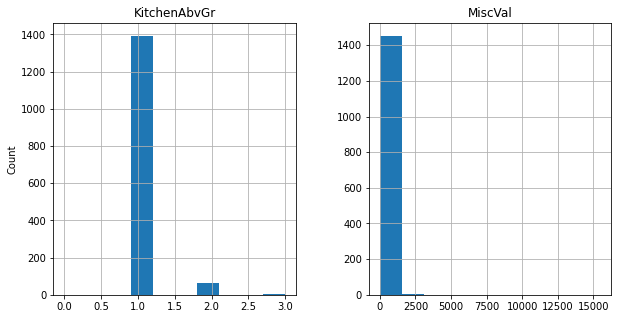

In [ ]:
#plot some numerical variables
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
df.hist('KitchenAbvGr', ax = ax1)
df.hist('MiscVal', ax = ax2)
ax1.set_ylabel('Count');

When initially looking at the data, one area of concern is that some variables contain only (or almost only) one value and may not be useful for our model. Among the categorical variables, we have examples like 'Street', 'Utilities', 'RoofMatl', and 'Heating'. Among the numerical variables, there's 'KitchenAbvGr', 'MiscVal', 'LowQualFinSF', 'EnclosedPorch'. Note for the graph: since some quantitative variables contain too many different values, I have labeled all of the values that are not the mode as the "Other" category

In [ ]:
#turn integers in the numerical data into strings for plotting purposes
df_bar = df.copy()
df_bar['KitchenAbvGr'] = [str(i) for i in df_bar['KitchenAbvGr']]
df_bar['MiscVal'] = [str(i) for i in df_bar['MiscVal']]
df_bar['LowQualFinSF'] = [str(i) for i in df_bar['LowQualFinSF']]
df_bar['EnclosedPorch'] = [str(i) for i in df_bar['EnclosedPorch']]

#convert all values that are not the mode into the 'Other' category
for i in range(len(df_bar['KitchenAbvGr'])):
  if(((df_bar['KitchenAbvGr'][i]) != (df_bar['KitchenAbvGr'].mode())).all()):
    (df_bar['KitchenAbvGr'][i]) = 'Other'
for i in range(len(df_bar['MiscVal'])):
  if(((df_bar['MiscVal'][i]) != (df_bar['MiscVal'].mode())).all()):
    (df_bar['MiscVal'][i]) = 'Other'
for i in range(len(df_bar['LowQualFinSF'])):
  if(((df_bar['LowQualFinSF'][i]) != (df_bar['LowQualFinSF'].mode())).all()):
    (df_bar['LowQualFinSF'][i]) = 'Other'
for i in range(len(df_bar['EnclosedPorch'])):
  if(((df_bar['EnclosedPorch'][i]) != (df_bar['EnclosedPorch'].mode())).all()):
    (df_bar['EnclosedPorch'][i]) = 'Other'


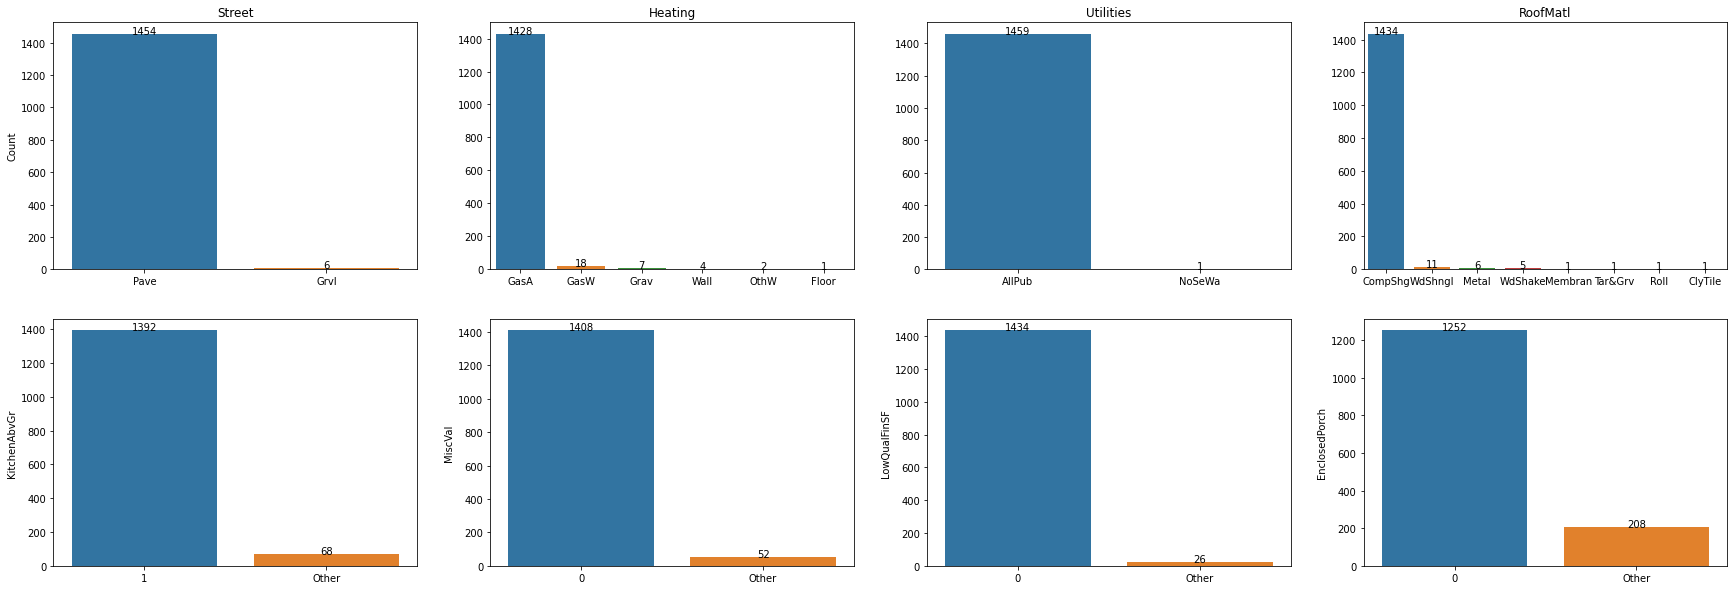

In [ ]:
#plot some categorical and numerical variables
#note: used geeksforgeeks.org code to help add labels for values
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize = (30,10))
def addlabels(x,y,axs):
    for i in range(len(x)):
        axs.text(i, y[i], y[i], ha = 'center')
sns.barplot(x = df.loc[:, 'Street'].unique(), y = df.loc[:, 'Street'].value_counts(), ax = ax1)
addlabels(df.loc[:, 'Street'].unique(), df.loc[:, 'Street'].value_counts(), ax1)
sns.barplot(x = df.loc[:, 'Heating'].unique(), y = df.loc[:, 'Heating'].value_counts(), ax = ax2)
addlabels(df.loc[:, 'Heating'].unique(), df.loc[:, 'Heating'].value_counts(), ax2)
sns.barplot(x = df.loc[:, 'Utilities'].unique(), y = df.loc[:, 'Utilities'].value_counts(), ax = ax3)
addlabels(df.loc[:, 'Utilities'].unique(), df.loc[:, 'Utilities'].value_counts(), ax3)
sns.barplot(x = df.loc[:, 'RoofMatl'].unique(), y = df.loc[:, 'RoofMatl'].value_counts(), ax = ax4)
addlabels(df.loc[:, 'RoofMatl'].unique(), df.loc[:, 'RoofMatl'].value_counts(), ax4)
sns.barplot(x = df_bar.loc[:, 'KitchenAbvGr'].unique(), y = df_bar.loc[:, 'KitchenAbvGr'].value_counts(), ax = ax5)
addlabels(df_bar.loc[:, 'KitchenAbvGr'].unique(), df_bar.loc[:, 'KitchenAbvGr'].value_counts(), ax5)
sns.barplot(x = df_bar.loc[:, 'MiscVal'].unique(), y = df_bar.loc[:, 'MiscVal'].value_counts(), ax = ax6)
addlabels(df_bar.loc[:, 'MiscVal'].unique(), df_bar.loc[:, 'MiscVal'].value_counts(), ax6)
sns.barplot(x = df_bar.loc[:, 'LowQualFinSF'].unique(), y = df_bar.loc[:, 'LowQualFinSF'].value_counts(), ax = ax7)
addlabels(df_bar.loc[:, 'LowQualFinSF'].unique(), df_bar.loc[:, 'LowQualFinSF'].value_counts(), ax7)
sns.barplot(x = df_bar.loc[:, 'EnclosedPorch'].unique(), y = df_bar.loc[:, 'EnclosedPorch'].value_counts(), ax = ax8)
addlabels(df_bar.loc[:, 'EnclosedPorch'].unique(), df_bar.loc[:, 'EnclosedPorch'].value_counts(), ax8)
ax1.set_ylabel('Count')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax1.set_title('Street')
ax2.set_title('Heating')
ax3.set_title('Utilities')
ax4.set_title('RoofMatl');



After looking at these variables, we decide to drop two extreme cases: Street and Utilities.

In [ ]:
df.drop(['Street', 'Utilities'], axis=1, inplace=True)

* Train test split

Now that we've narrowed our predictors by a little bit, we will use one-hot encoding for the categorical variables and then split the data into a train and test set. We will use a 75 - 25 split. We will be stratifying on the response variable SalePrice since it is skewed (as shown in the next section). 

Note: There is a possibility that one or more classes of each category might appear in the test set and not training set. We do one hot encoding before training so that each possible class is encoded, so there will not be any predictor that the model has not seen before. The predictions will not be affected by this step. For the numerical variables we should impute after split.

In [ ]:
#create variable PriceRange that divides SalePrice into 
#different categories for stratified sampling
df['PriceRange'] = np.zeros(len(df))
df.loc[((0 <= df['SalePrice']) & (df['SalePrice'] <= 150000)), 'PriceRange'] = 1
df.loc[((150000 < df['SalePrice']) & (df['SalePrice'] <= 300000)), 'PriceRange'] = 2
df.loc[((300000 < df['SalePrice']) & (df['SalePrice'] <= 450000)), 'PriceRange'] = 3
df.loc[((450000 < df['SalePrice']) & (df['SalePrice'] <= 600000)), 'PriceRange'] = 4
df.loc[((600000 < df['SalePrice']) & (df['SalePrice'] <= df['SalePrice'].max())), 'PriceRange'] = 5

In [ ]:
#use one-hot encoding, drop one of the columns to avoid dummy variable trap 
data = pd.get_dummies(df, dummy_na = True, drop_first = True)

In [ ]:
#set X as predictors and Y as response variable
X = data.drop(['SalePrice', 'PriceRange'], axis=1)
Y = data['SalePrice']
#split data into train/test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, stratify = df['PriceRange'], random_state = 123)
#save training indices for future reference
train_indices = X_train.index

# Examine the data


The training dataset consists of 1095 observations and testing set consists of 365 observations. As shown in the graphs below, the distribution of our response variable is very similar in the train, test, and actual datasets. This is what we want. The rest of our EDA and learning will be based solely on the training data. 

* The response variable

Since our response variable 'SalePrice' is quantitative, we will be using a regression approach. However, since 'SalePrice' seems skewed and could have potential outliers, this may pose problems to the model.

Skewness: 1.972269
Kurtosis: 7.191944


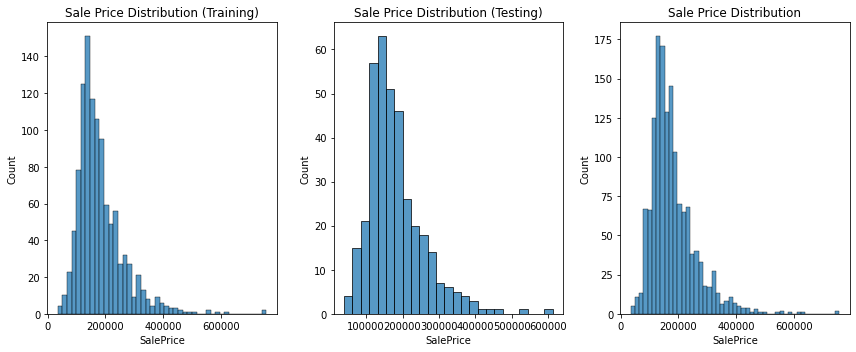

In [ ]:
#plot sale price distribution for training, test, and actual datasets
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,5))
sns.histplot(Y_train, ax = ax1)
sns.histplot(Y_test, ax = ax2)
sns.histplot(df['SalePrice'], ax = ax3)
ax1.title.set_text('Sale Price Distribution (Training)')
ax2.title.set_text('Sale Price Distribution (Testing)')
ax3.title.set_text('Sale Price Distribution')
fig.tight_layout()
print("Skewness: %f" % Y_train.skew())
print("Kurtosis: %f" % Y_train.kurt())

Log transforming 'SalePrice' results in a (approximate) normal distribution as shown below. This is something to keep in mind. 

Text(0.5, 0, 'Log SalePrice')

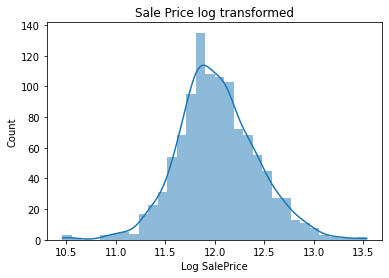

In [ ]:
sns.histplot(np.log(Y_train), kde=True, stat="count", linewidth=0) #plot log transformed SalePrice
plt.title('Sale Price log transformed')
plt.xlabel('Log SalePrice')

* Correlation between predictors and the response variable

Now lets have a closer look at the data, specifically on the relation between predictors and the response. Below is bar plot of the correlation of numerical variables with sale price. 

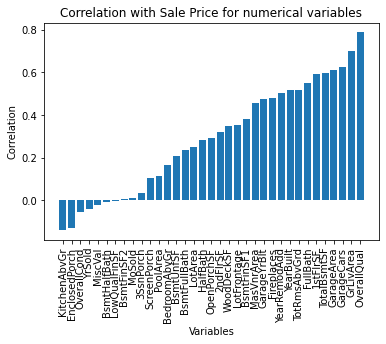

In [ ]:
#find correlation with Sale Price
corr_saleprice = pd.concat([X_train.loc[:, 'LotFrontage':'YrSold'], Y_train], axis = 1).corr()['SalePrice'].drop('SalePrice').sort_values()
corr_sp_df = pd.DataFrame(corr_saleprice)
#plot bar graph of the correlation
plt.bar(corr_saleprice.index, corr_saleprice.values)
plt.xticks(rotation = 'vertical')
plt.xlabel("Variables")
plt.ylabel("Correlation")
plt.title("Correlation with Sale Price for numerical variables");

As shown in the bar chart above, the vast majority of predictors have a positive relationship with sale price and there are no predictors with a strong negative relationship with sale price. Also as one might have expected, overall quality and living area have a strong relationship with sale price. We can theorize that OverallQual and GrLivArea could be important predictors.

Now we will plot overall quality and living area versus sale price.

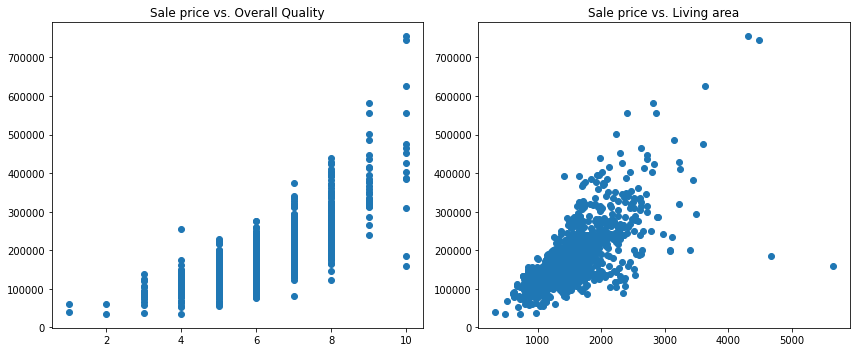

In [ ]:
#plot sale price vs. overall quality and living area
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))
ax1.scatter(x = X_train['OverallQual'], y = Y_train)
ax2.scatter(x = X_train['GrLivArea'], y = Y_train)
ax1.title.set_text('Sale price vs. Overall Quality')
ax2.title.set_text('Sale price vs. Living area')
fig.tight_layout()

Although overall quality and living area have a strong positive relationship with sale price, it seems like they become worse predictors of sale price as their values increase. 

Let's see how overall quality and living area are distributed.

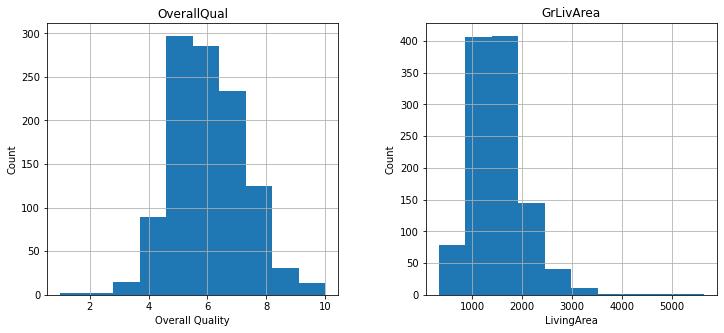

In [ ]:
#plot distribution of overall quality and living area
fig, ax = plt.subplots(1, 2, figsize = (12,5))
X_train.hist('OverallQual', ax = ax[0])
X_train.hist('GrLivArea', ax = ax[1])
ax[0].set_xlabel('Overall Quality')
ax[0].set_ylabel('Count')
ax[1].set_xlabel('LivingArea')
ax[1].set_ylabel('Count');

Overall quality has an approximate normal distribution. Living area is right-skewed and most of its values are between 1000 to 2000 square feet. As shown in the scatterplot above, these predictors tend to produce weaker predictors of sale price for higher values. Since both of these predictors have relatively few values on the high end, they should be decent predictors of sale price for our model. 

Full bathrooms, year built, total rooms, and remodel date are also interesting variables to take a look at since you'd expect them to have a strong relationship with sale price. 

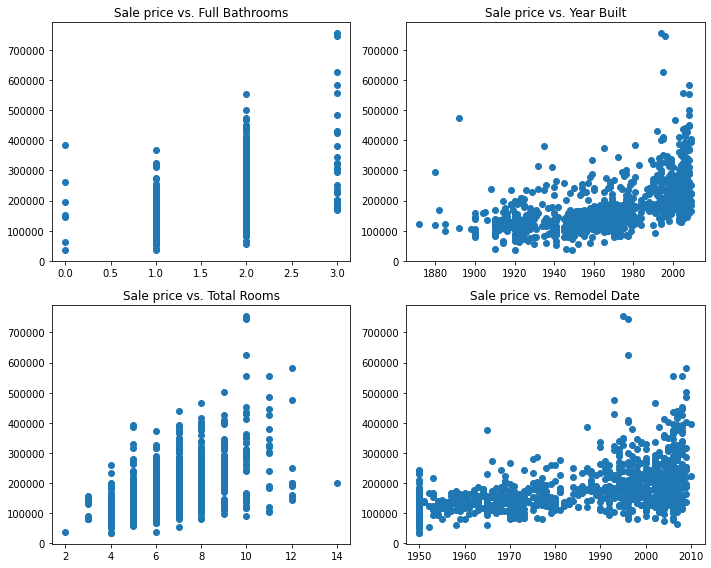

In [ ]:
#plot full bathrooms, year built, total rooms, and remodel date against sale price
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (10,8))
ax1.scatter(X_train['FullBath'], Y_train)
ax2.scatter(X_train['YearBuilt'], Y_train)
ax3.scatter(X_train['TotRmsAbvGrd'], Y_train)
ax4.scatter(X_train['YearRemodAdd'], Y_train)
ax1.title.set_text('Sale price vs. Full Bathrooms')
ax2.title.set_text('Sale price vs. Year Built')
ax3.title.set_text('Sale price vs. Total Rooms')
ax4.title.set_text('Sale price vs. Remodel Date')
fig.tight_layout();

It kind of surprised me that these variables didn't have a stronger correlation with sale price. Year built and remodel rate seem to correlate relatively strongly with sale price prior to 1985, but not as strongly after 1985. Total rooms and bathrooms have a moderately strong correlation with sale price. The observation with 14 rooms and a sale price of 200000 seems like an outlier. 

Let's take a look at the distribution of year built to get a better understanding of the data. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a4a75cad0>]],
      dtype=object)

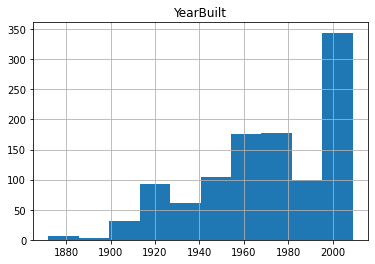

In [ ]:
X_train.hist('YearBuilt')

Interesting. Many of the houses we will be analyzing are newer homes built after 1990. But there are still a decent number of homes built between 1940-1990 with fewer number of homes built before 1940. 

Besides the correlation between predictors and the response variable, we also need to be aware of colinearity between certain predictors. Below is a heatmap of correlations between numerical predictors. 

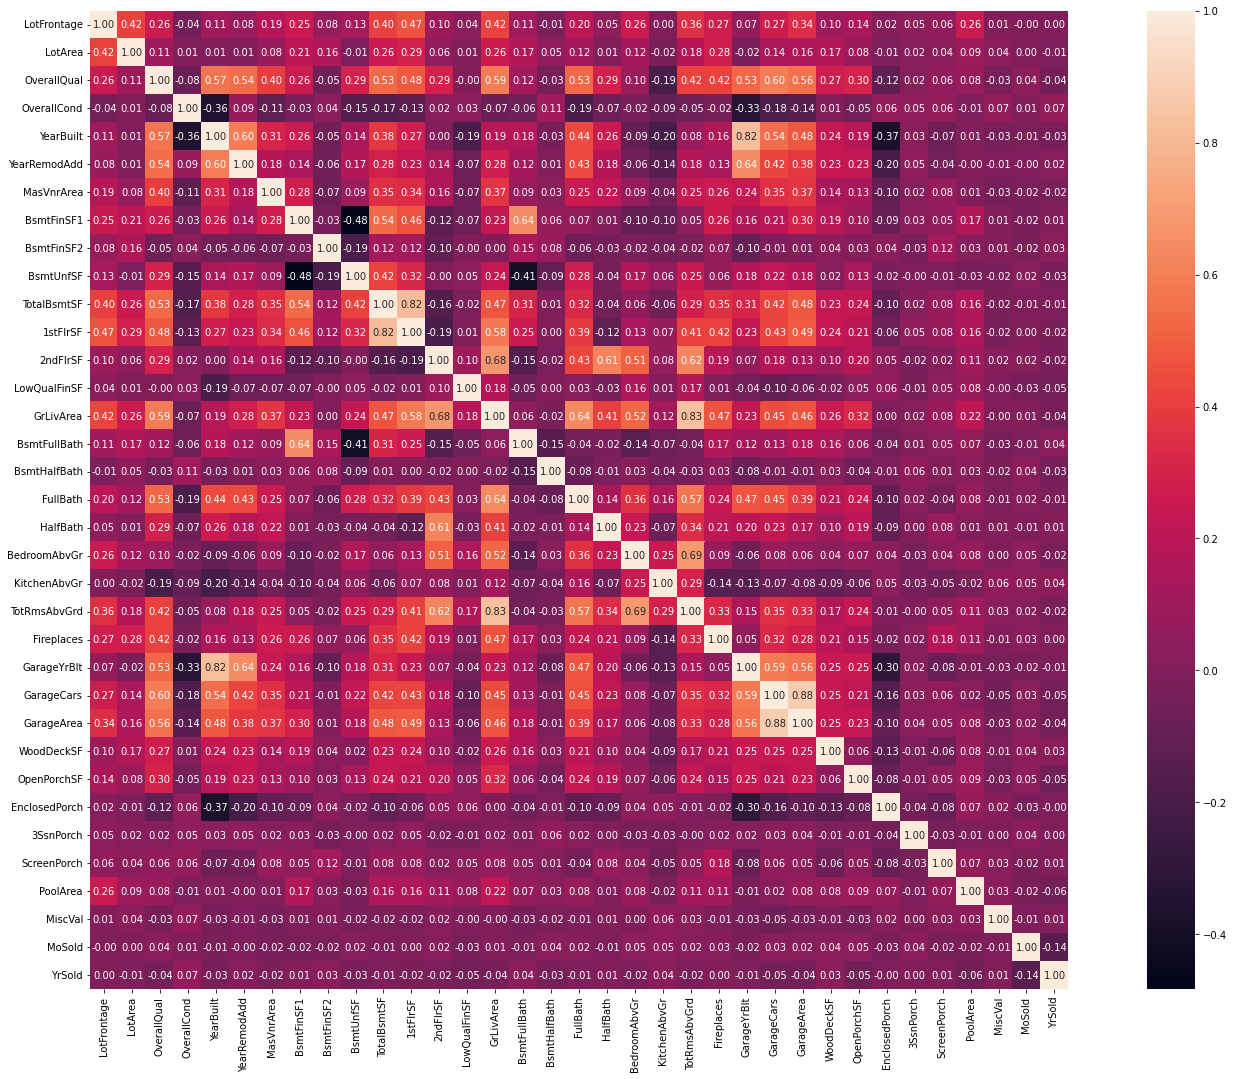

In [ ]:
numerical_train = X_train.loc[:, 'LotFrontage':'YrSold'] #quantitative data from training set 
#display heatmap
f, ax = plt.subplots(figsize=(28, 18))
sns.heatmap(numerical_train.corr(), annot = True, square=True, fmt = '.2f');

As you can see, there are several pairs of predictors that have a high correlation:
*   'GarageArea' and 'GarageCars' have a correlation of 0.88
*   'TotRmsAbvGrd' and 'GrLivArea' have a correlation of 0.83
*   'TotalBsmtSF' and '1stFlrSF' have a correlation of 0.82
*   'YearBuilt' and 'GarageYrBlt' have a correlation of 0.80


To reduce collinearity, we will remove one of the variables from each of these pairs for our model. 

In [ ]:
#drop variables
X_train.drop(columns = ['GarageCars', 'TotRmsAbvGrd', '1stFlrSF', 'GarageYrBlt'], inplace = True)
X_test.drop(columns = ['GarageCars', 'TotRmsAbvGrd', '1stFlrSF', 'GarageYrBlt'], inplace = True)

Now let's explore some of the categorical variables. An interesting predictor that pops out is land slope. As someone who cannot stand living on a hill, I would expect houses built on steep hills to sell for less. 

In [ ]:
#get categorical columns for training data
num_cols = df._get_numeric_data().columns #numeric columns
cat_cols = np.array(list(set(df.columns) - set(num_cols)))

Text(0.5, 1.0, 'Distribution of Land Slope')

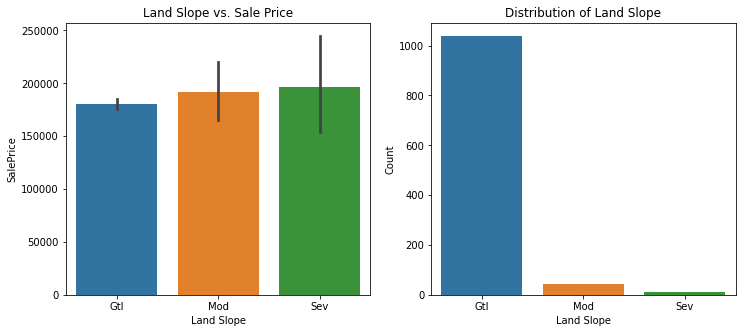

In [ ]:
#plot land slope vs. sale price and also distribution of land slope 
fig, ax = plt.subplots(1, 2, figsize = (12,5))
sns.barplot(x = 'LandSlope', y = 'SalePrice', data = pd.concat(
    [df.loc[train_indices, cat_cols], df.loc[train_indices, 'SalePrice']], axis = 1), ax = ax[0])
sns.barplot(x = df.loc[train_indices, 'LandSlope'].unique(), y = df.loc[train_indices, 'LandSlope'].value_counts(), ax = ax[1])
ax[0].set_xlabel('Land Slope')
ax[0].set_ylabel('SalePrice')
ax[0].set_title('Land Slope vs. Sale Price')
ax[1].set_xlabel('Land Slope')
ax[1].set_ylabel('Count')
ax[1].set_title('Distribution of Land Slope')

Wow, this was completely unexpected. Houses built on severe slope sold for the highest. However, since the vast majority of houses are gentle slope, I suspect the data may not be accurate. Notice that the confidence intervals for the moderate and severe slope are also very high (plot on the left). 

It's also worth exploring whether the quality of various elements of the house affect the sale price. 

Text(0, 0.5, '')

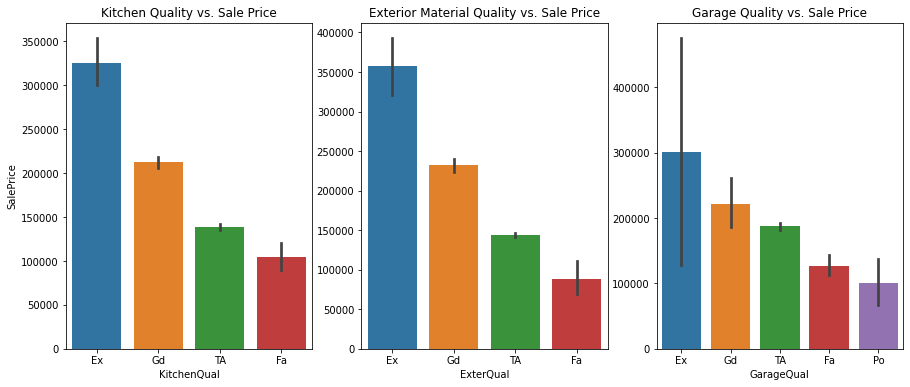

In [ ]:
#plot quality of various elements vs. sale price
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,6))
order1 = ['Ex', 'Gd', 'TA', 'Fa'] #set order
order2 = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
sns.barplot(x = 'KitchenQual', y = 'SalePrice', data = pd.concat(
    [df.loc[train_indices, cat_cols], df.loc[train_indices, 'SalePrice']], axis = 1), order = order1, ax = ax1, label = ['Excellent', 'Good', 'Average', 'sf', 'ad'])
sns.barplot(x = 'ExterQual', y = 'SalePrice', data = pd.concat(
    [df.loc[train_indices, cat_cols], df.loc[train_indices, 'SalePrice']], axis = 1), order = order1, ax = ax2)
sns.barplot(x = 'GarageQual', y = 'SalePrice', data = pd.concat(
    [df.loc[train_indices, cat_cols], df.loc[train_indices, 'SalePrice']], axis = 1), order = order2, ax = ax3)
#sns.barplot(x = 'Condition1', y = 'SalePrice', data = pd.concat(
    #[df.loc[train_indices, cat_cols], df.loc[train_indices, 'SalePrice']], axis = 1), ax = ax4)
ax1.set_title('Kitchen Quality vs. Sale Price')
ax2.set_title('Exterior Material Quality vs. Sale Price')
ax3.set_title('Garage Quality vs. Sale Price')
ax2.set_ylabel('')
ax3.set_ylabel('')
#ax4.set_title('Kitchen Quality vs. Sale Price')

As expected, the better the quality, the higher the sale price. 

Let's see if the type of building and house have an effect on sale price. 

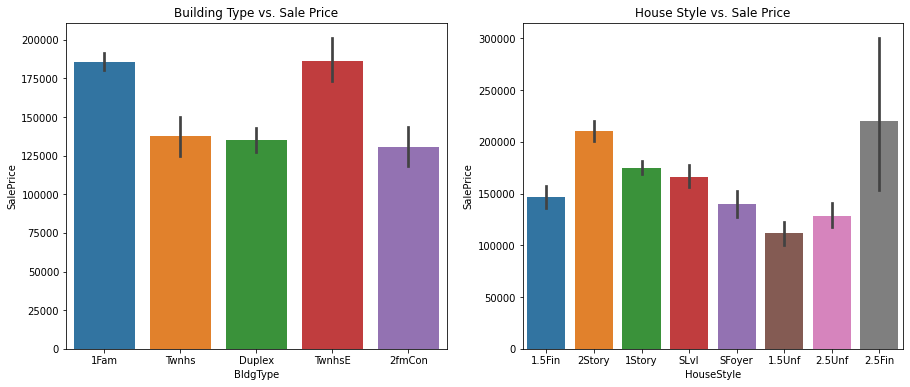

In [ ]:
#plot BldgType and HouseStyle vs. sale price
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,6))
sns.barplot(x = 'BldgType', y = 'SalePrice', data = pd.concat(
    [df.loc[train_indices, cat_cols], df.loc[train_indices, 'SalePrice']], axis = 1), ax = ax1)
sns.barplot(x = 'HouseStyle', y = 'SalePrice', data = pd.concat(
    [df.loc[train_indices, cat_cols], df.loc[train_indices, 'SalePrice']], axis = 1), ax = ax2)
ax1.set_title('Building Type vs. Sale Price')
ax2.set_title('House Style vs. Sale Price');

Seems like building type doesn't have a major impact on sale price. But houses with more levels and 2nd level finished sold for more. 

# Dealing with missing data

There is still missing observations in the data. Below is a list of the number of observations missing for a particular predictor.

In [ ]:
train_datamissing = X_train.loc[:, X_train.isnull().sum() > 0] #columns that still have data missing
#number of observations missing for each column
sum_datamissing = X_train.loc[:, X_train.isnull().sum() > 0].isnull().sum()
print(sum_datamissing)

LotFrontage    190
MasVnrArea       4
dtype: int64


Since there is no large portion of values of any variable or obervation missing, we will not drop any observation or variable. We will be imputing these missing values using k-nearest neighbors (kNN) technique. 

In [ ]:
#KNN imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
original_columns = X_train.columns
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Data Preprocessing

Since a few of potential models such as regularization are sensitive to the scale of the data, we need to scale it before feeding into the models.

In [ ]:
#scale the predictors to distributions of mean 0 and standard deviation of 1 so the coefficients will not be affected by the scale.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

Now our training data has 1095 observations and 281 predictors.

In [ ]:
X_train.shape

(1095, 281)

# Fitting models

* We now fit several models with cross validation to find the best parameters. Our metric is Mean Absolute Error (MAE). 

Side note: sklearn package uses negative MAE because this way the biggest negative MAE is the best score.

* We tune the models using RandomizedSearchCV to search for 25 random combinations of the parameters we provide. Since some models have multiple tuning parameters, calculating scores for all combinations is time consuming.

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

* Linear Regression

We choose linear regression as our baseline model. As one can see linear regression has a big cross validation MAE. It seems that linear regression overfits heavily.

In [ ]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
train_error_lr = mean_absolute_error(Y_train, lr.predict(X_train))
cv_error_lr = cross_val_score(lr, X_train, Y_train, scoring='neg_mean_absolute_error', cv=5).mean()
print('training error: {}\ncross validation error: {}'.format(train_error_lr, cv_error_lr))

training error: 13485.296915467883
cross validation error: -5833391690959448.0


* Lasso Regression

Lasso can do feature selection. The default penalization parameter alpha is 1.

In [ ]:
# fit a lasso model with a tolerance
lasso = Lasso(tol=0.005)
default_lasso = cross_val_score(lasso, X_train, Y_train, scoring='neg_mean_absolute_error', cv=5).mean()
default_lasso

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.010e+10, tolerance: 2.877e+10
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.719e+10, tolerance: 2.994e+10
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

-21738.424361415986

In [ ]:
#tune Lasso model, find the best parameter from a given list
param_grid = {'alpha': list(range(100, 2001, 100))}
lasso_tuned = GridSearchCV(lasso, param_grid, n_jobs=-1, scoring='neg_mean_absolute_error', cv=5)
lasso_tuned.fit(X_train, Y_train)

#get best alpha 
print('Best alpha: ' + str(lasso_tuned.best_params_.get('alpha')))

#get mean cross validation MAE corresponding to best alpha
print('Cross validation negative MAE for best alpha: ' + str(lasso_tuned.best_score_))

Best alpha: 400
Cross validation negative MAE for best alpha: -19230.078997732817




*   Gradient Boosting

Next we try a gradient boosting regressor. 


In [ ]:
#fit Gradient Boosting model using default parameters
gbr = GradientBoostingRegressor(random_state=0)
default_gbr = cross_val_score(gbr, X_train, Y_train, scoring='neg_mean_absolute_error', cv=5).mean()
default_gbr

-17637.381686988483

Here we use RandomizedSearchCV to tune the hyperparameters of the Gradient Boosting model, specifically learning_rate, n_estimators, max_depth, and max_features.

In [ ]:
param_grid = {
  'learning_rate': np.arange(0.01, 0.5, step=0.01),
  'n_estimators': np.arange(50, 150, step=10), 
  'max_depth': list(range(1, 6)), 
  'max_features': ['auto', 'sqrt', 'log2']
  }
gbr_tuned = RandomizedSearchCV(estimator = gbr,
                               param_distributions = param_grid,
                               cv = 5,
                               n_iter = 25,
                               scoring = 'neg_mean_absolute_error',
                               random_state = 0,
                               n_jobs=-1)
gbr_tuned.fit(X_train, Y_train)

#get best paramters 
print('Best parameters: ' + str(gbr_tuned.best_params_))

#get mean cross validation MAE corresponding to best parameters
print('Cross validation negative MAE for best parameters: ' + str(gbr_tuned.best_score_))

Best parameters: {'n_estimators': 70, 'max_features': 'auto', 'max_depth': 5, 'learning_rate': 0.15000000000000002}
Cross validation negative MAE for best parameters: -17966.361886981256


The default parameters can produce pretty good scores already. There is no significant improvement from tuning.

* Random Forest

We define a random forest regressor with default parameters on the data.

In [ ]:
#fit Random Forest model using default parameters
rf_model_untuned = RandomForestRegressor()
default_rf = cross_val_score(rf_model_untuned, X_train, Y_train, scoring='neg_mean_absolute_error', cv=5).mean()
default_rf

-19001.88097716895

Here we use RandomizedSearchCV to tune the hyperparameters of the Random Forest model, specifically n_estimators, max_depth, and max_features. 

In [ ]:
#fit Random Forest model, tune hyperparameters
params = {
    'n_estimators': list(range(25,150)),
    'max_depth': list(range(1,50)),
    'max_features': ['auto', 'sqrt', 'log2']
}
rf_model = RandomizedSearchCV(estimator = RandomForestRegressor(),
                              param_distributions = params,
                              cv = 5,
                              n_iter = 25,
                              scoring = 'neg_mean_absolute_error',
                              random_state = 0)
rf_model.fit(X_train, Y_train)

#get best paramters 
print('Best parameters: ' + str(rf_model.best_params_))

#get mean cross validation MAE corresponding to best parameters
print('Cross validation negative MAE for best parameters: ' + str(rf_model.best_score_))

Best parameters: {'n_estimators': 116, 'max_features': 'sqrt', 'max_depth': 17}
Cross validation negative MAE for best parameters: -18981.022024088546


* AdaBoostRegressor

In [ ]:
ada = AdaBoostRegressor(random_state=0)
default_ada = cross_val_score(ada, X_train, Y_train, scoring='neg_mean_absolute_error', cv=5).mean()
default_ada

-24964.850053374117

We use RandomizedSearchCV to tune the AdaBoostRegressor.

In [ ]:
param_grid = {
  'learning_rate': np.arange(0.1, 2.1, step=0.1),
  'n_estimators': np.arange(25, 75, step=5), 
  'loss': ['linear', 'square', 'exponential']
  }
ada_tuned = RandomizedSearchCV(estimator = ada,
                               param_distributions = param_grid,
                               cv = 5,
                               n_iter = 25,
                               scoring = 'neg_mean_absolute_error',
                               random_state = 0,
                               n_jobs=-1)
ada_tuned.fit(X_train, Y_train)
#best parameters
print('Best parameters: ' + str(ada_tuned.best_params_))

#get mean cross validation MAE corresponding to best parameters
print('Cross validation negative MAE for best parameters: ' + str(ada_tuned.best_score_))

Best parameters: {'n_estimators': 50, 'loss': 'exponential', 'learning_rate': 0.7000000000000001}
Cross validation negative MAE for best parameters: -24174.877789364604


In [ ]:
models_comparison = {'LinearRegression': [cv_error_lr, 'N/A'],
                     'Lasso': [default_lasso, lasso_tuned.best_score_], 
                     'GradientBoostingRegressor': [default_gbr, gbr_tuned.best_score_], 
                     'RandomForestRegressor': [default_rf, rf_model.best_score_],
                     'AdaBoostRegressor': [default_ada, ada_tuned.best_score_]
                     }
pd.DataFrame(models_comparison, index = [['error', 'error'], ['default parameters', 'tuned parameters']])

LinearRegression         Lasso  \
error default parameters -5833391690959448.0 -21738.424361   
      tuned parameters                   N/A -19230.078998   

                          GradientBoostingRegressor  RandomForestRegressor  \
error default parameters              -17637.381687          -19001.880977   
      tuned parameters                -17966.361887          -18981.022024   

                          AdaBoostRegressor  
error default parameters      -24964.850053  
      tuned parameters        -24174.877789

Table 1: Various regression models' default and RandomSearch tuned performance.

## Result

All other models except linear regression can lower the MAE of cross validated house prices to around 20000 dollars, which is not bad at all, given the house price range from a few hundred thousand to millions. As shown in table 1, we observe that Gradient Boosting has the lowest cross validation error among the models we choose. In fact, the default parameters by sklearn already performs pretty well for our data.

## Prediction

Since Gradient Boosting has the lowest cross validation error, we use it for prediction.

In [ ]:
preds = gbr_tuned.predict(X_test)
mean_absolute_error(Y_test, preds)

15984.776335110082

## A little experiment on neural network with keras

We build a prototype of a neural network with regularization using tensorflow keras, and it also performs relatively well. If time permits, we would like to work on it more.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=X_train[0].shape))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae')

history = model.fit(X_train, Y_train, validation_split=0.2, epochs=200, callbacks=[EarlyStopping(patience=2)], batch_size=50)

Epoch 1/200
18/18 [==============================] - 3s 14ms/step - loss: 181934.0156 - val_loss: 176980.9062
Epoch 2/200
18/18 [==============================] - 0s 5ms/step - loss: 181921.7344 - val_loss: 176963.3594
Epoch 3/200
18/18 [==============================] - 0s 5ms/step - loss: 181892.9844 - val_loss: 176922.3438
Epoch 4/200
18/18 [==============================] - 0s 6ms/step - loss: 181828.4688 - val_loss: 176831.9375
Epoch 5/200
18/18 [==============================] - 0s 6ms/step - loss: 181696.6875 - val_loss: 176658.5000
Epoch 6/200
18/18 [==============================] - 0s 5ms/step - loss: 181459.5312 - val_loss: 176357.0000
Epoch 7/200
18/18 [==============================] - 0s 5ms/step - loss: 181072.6094 - val_loss: 175887.6719
Epoch 8/200
18/18 [==============================] - 0s 5ms/step - loss: 180483.4531 - val_loss: 175196.9844
Epoch 9/200
18/18 [==============================] - 0s 5ms/step - loss: 179641.5156 - val_loss: 174241.4844
Epoch 10/200
18/18

plot loss as iteration increases

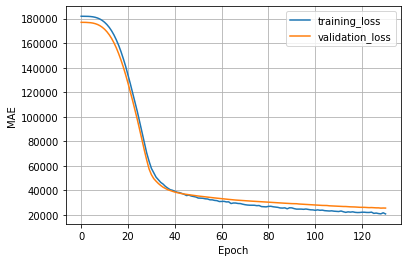

In [ ]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

## conclusion

In this project, we have explored features and models that could be useful to predict house prices given certain information about the houses. In terms of features, lasso regression penalizes certain coefficients and thus gets a significantly better score than linear regression. In terms of models, boosting methods perform well by learning bit by bit, and random forest is able to break down the feature list and learn from there. 

Given the limited time for this project, we did limited improvements and extraction of features in this dataset, and we left a prototype of neural network in the appendix. Future works may include extract better features from features such as qualities of various components of a house, and tune the neural network a little more. 